<a href="https://colab.research.google.com/github/mayafetzer/ForestFirePrediction/blob/main/ForestFirePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maya Fetzer
CHEG 472
Forest Fire Prediction

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
import math
import pickle

Step 1: Examine the data

In [ ]:
# Load the dataset
file_name = '/content/wildfire_prediction_multi_output_dataset_v2.xlsx'  # Ensure this file is in the same directory as your script
df = pd.read_excel(file_name)

In [ ]:
df.head()
df.describe()

,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Fuel Moisture (%),Slope (%),Fire Size (hectares),Fire Duration (hours),Suppression Cost ($)
count,4753.000000,4750.000000,4750.000000,4750.000000,4750.000000,5000.000000,4756.000000,4750.000000,4750.000000
mean,30.559802,49.377604,20.147253,25.295303,22.510023,29.956677,263.269659,59.818449,248881.334377
std,9.402463,23.205739,11.539852,14.435450,10.046614,17.301284,176.795086,34.883902,145005.668615
min,15.002875,10.003265,0.031548,0.010413,5.005384,0.015012,0.078304,0.008886,1068.279487
25%,22.539120,29.010613,10.172871,12.924704,13.795764,14.850011,125.423007,29.641224,121385.330783
50%,30.503760,48.865124,20.134280,25.452002,22.374514,29.899970,252.202772,59.680007,248508.829418
75%,37.984770,69.060730,30.397929,37.959436,31.135407,45.040702,380.896312,90.160282,374646.904065
max,56.131937,89.974529,39.997698,49.999283,39.995114,59.989769,971.349463,119.994633,499980.374078


In [ ]:
# Check the data types of each column
column_types = df.dtypes

print("Column types:\n", column_types)

Column types:
 Temperature (°C)         float64
Humidity (%)             float64
Wind Speed (km/h)        float64
Rainfall (mm)            float64
Fuel Moisture (%)        float64
Vegetation Type           object
Slope (%)                float64
Region                    object
Fire Size (hectares)     float64
Fire Duration (hours)    float64
Suppression Cost ($)     float64
Fire Occurrence           object
dtype: object


Step 2: Preprocess the data

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("Duplicate rows:", duplicate_rows)

Missing values:
 Temperature (°C)         247
Humidity (%)             250
Wind Speed (km/h)        250
Rainfall (mm)            250
Fuel Moisture (%)        250
Vegetation Type            0
Slope (%)                  0
Region                     0
Fire Size (hectares)     244
Fire Duration (hours)    250
Suppression Cost ($)     250
Fire Occurrence            0
dtype: int64
Duplicate rows: 0


In [ ]:
# For this code, I am choosing dropping rows with missing data. I am choosing this method because
# if this dataset is to be used later for machine learning purposes, it is better to have the dataset
# contain no missing data points. This would allow for regression/correlation analysis to not be skewed
# by the values if I was to replace the missing value with another number.

df_cleaned = df.dropna()

# Check again for missing data
missing_data = df_cleaned.isnull().sum()
print("Total missing values for each column:")
missing_data[missing_data > 0]

# There are no duplicate columns, so we do not have to worry about dropping those.

Total missing values for each column:


,0


Outliers in column 'Temperature (°C)': 0
Outliers in column 'Humidity (%)': 0
Outliers in column 'Wind Speed (km/h)': 0
Outliers in column 'Rainfall (mm)': 0
Outliers in column 'Fuel Moisture (%)': 0
Outliers in column 'Slope (%)': 0
Outliers in column 'Fire Size (hectares)': 0
Outliers in column 'Fire Duration (hours)': 0
Outliers in column 'Suppression Cost ($)': 0


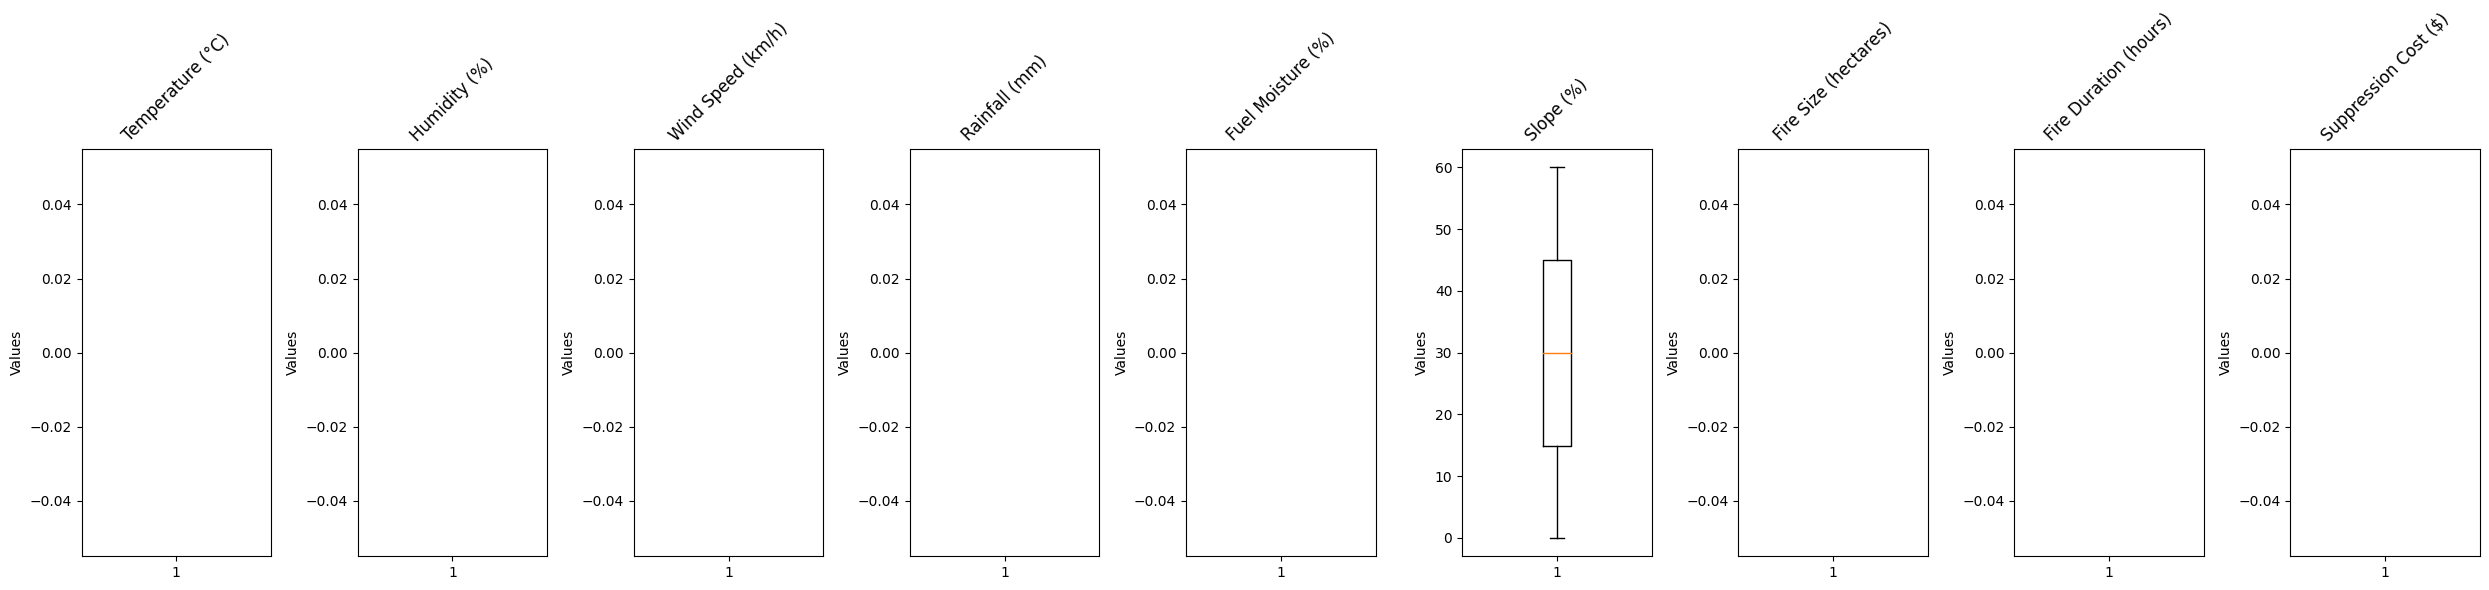

In [ ]:
# Count and display the number of outliers in the df

# Calculate outliers for each column
outliers_dict = {}

# Only check the columns that are numerical and would contain outliers
columns_to_check = df.select_dtypes(include=['int64', 'float64']).columns

# Check for outliers and count them
for col in columns_to_check:
    q1 = np.quantile(df[col], 0.25)
    q3 = np.quantile(df[col], 0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers.tolist()

    # Print the total number of outliers for the current column
    print(f"Outliers in column '{col}': {len(outliers)}")

# Create a figure with subplots for each column
fig, axes = plt.subplots(1, len(columns_to_check), figsize=(25, 6))  # Adjust figsize as needed

# Iterate through each column and create a boxplot on its own subplot
for i, col in enumerate(columns_to_check):
  q1 = np.quantile(df[col], 0.25)
  q3 = np.quantile(df[col], 0.75)
  axes[i].boxplot([df[col]])  # Plot data for a single column
  axes[i].set_title(col, rotation=45)  # Set title and rotate it by 45 degrees
  axes[i].set_ylabel('Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

There are no outliers in this dataset so we do not have to worry about removing the outliers.

Step 3: Make a machine learning model and export using pickle

In [ ]:
# One-hot encode the specified columns
df_encoded = pd.get_dummies(df, columns=['Fire Occurrence', 'Vegetation Type', 'Region'], drop_first=True)

# Fill NaN values with 0 (or another appropriate value)
df_encoded = df_encoded.fillna(0)

# Convert the DataFrame to integers
df_encoded = df_encoded.astype(int)

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

# Display the data types of the columns
print(df_encoded.dtypes)


   Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
0                27            89                 13             44   
1                28            21                 37             42   
2                30            72                 19             12   
3                17            84                  5              0   
4                34            62                 13             27   

   Fuel Moisture (%)  Slope (%)  Fire Size (hectares)  Fire Duration (hours)  \
0                 16         59                   442                     11   
1                 25         26                    17                      6   
2                 22         55                   256                    117   
3                 20          3                   165                     38   
4                  6         54                   160                     15   

   Suppression Cost ($)  Fire Occurrence_Yes  Vegetation Type_Grassland  \
0                

In [11]:
# Splitting the dataset into features and targets
X = df_encoded.drop(['Fire Occurrence_Yes', 'Suppression Cost ($)', 'Fire Duration (hours)', 'Fire Size (hectares)'], axis=1)
y_1 = df_encoded['Fire Occurrence_Yes']
y_2 = df_encoded['Suppression Cost ($)']
y_3 = df_encoded['Fire Duration (hours)']
y_4 = df_encoded['Fire Size (hectares)']

# Split data into train and test sets (80% train, 20% test) for each target
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y_2, test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y_3, test_size=0.2, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_4, test_size=0.2, random_state=42)

# Standardizing the data (for certain models like SVM)
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)
X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3 = scaler.transform(X_test_3)
X_train_scaled_4 = scaler.fit_transform(X_train_4)
X_test_scaled_4 = scaler.transform(X_test_4)

# Machine Learning Models
classification_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

regression_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR()
}

# Training and evaluating the classification model for Fire Occurrence
best_model_1 = None
best_rmse_1 = float('inf')

for model_name, model in classification_models.items():
    print(f"Training {model_name} for Fire Occurrence...")

    # Use scaled data for SVM, for others, use non-scaled data
    if model_name == "SVM":
        model.fit(X_train_scaled_1, y_train_1)
        y_test_pred_1 = model.predict(X_test_scaled_1)
    else:
        model.fit(X_train_1, y_train_1)
        y_test_pred_1 = model.predict(X_test_1)

    # Calculate RMSE for the test dataset
    rmse_test_1 = math.sqrt(mean_squared_error(y_test_1, y_test_pred_1))

    # Save the best model for Fire Occurrence based on RMSE
    if rmse_test_1 < best_rmse_1:
        best_rmse_1 = rmse_test_1
        best_model_1 = model
        best_model_name_1 = model_name

    print(f"{model_name} RMSE on Test Data for Fire Occurrence: {rmse_test_1}")

# Training and evaluating the regression model for Suppression Cost
best_model_2 = None
best_rmse_2 = float('inf')

for model_name, model in regression_models.items():
    print(f"Training {model_name} for Suppression Cost...")

    model.fit(X_train_scaled_2, y_train_2)
    y_test_pred_2 = model.predict(X_test_scaled_2)

    rmse_test_2 = math.sqrt(mean_squared_error(y_test_2, y_test_pred_2))

    if rmse_test_2 < best_rmse_2:
        best_rmse_2 = rmse_test_2
        best_model_2 = model
        best_model_name_2 = model_name

    print(f"{model_name} RMSE on Test Data for Suppression Cost: {rmse_test_2}")

# Training and evaluating the regression model for Fire Duration
best_model_3 = None
best_rmse_3 = float('inf')

for model_name, model in regression_models.items():
    print(f"Training {model_name} for Fire Duration...")

    model.fit(X_train_scaled_3, y_train_3)
    y_test_pred_3 = model.predict(X_test_scaled_3)

    rmse_test_3 = math.sqrt(mean_squared_error(y_test_3, y_test_pred_3))

    if rmse_test_3 < best_rmse_3:
        best_rmse_3 = rmse_test_3
        best_model_3 = model
        best_model_name_3 = model_name

    print(f"{model_name} RMSE on Test Data for Fire Duration: {rmse_test_3}")

# Training and evaluating the regression model for Fire Size
best_model_4 = None
best_rmse_4 = float('inf')

for model_name, model in regression_models.items():
    print(f"Training {model_name} for Fire Size...")

    model.fit(X_train_scaled_4, y_train_4)
    y_test_pred_4 = model.predict(X_test_scaled_4)

    rmse_test_4 = math.sqrt(mean_squared_error(y_test_4, y_test_pred_4))

    if rmse_test_4 < best_rmse_4:
        best_rmse_4 = rmse_test_4
        best_model_4 = model
        best_model_name_4 = model_name

    print(f"{model_name} RMSE on Test Data for Fire Size: {rmse_test_4}")

# Save the best models for each label
with open('best_model_fire_occurrence.pkl', 'wb') as f:
    pickle.dump(best_model_1, f)

with open('best_model_suppression_cost.pkl', 'wb') as f:
    pickle.dump(best_model_2, f)

with open('best_model_fire_duration.pkl', 'wb') as f:
    pickle.dump(best_model_3, f)

with open('best_model_fire_size.pkl', 'wb') as f:
    pickle.dump(best_model_4, f)

print(f"Best model for Fire Occurrence: {best_model_name_1} with RMSE: {best_rmse_1}")
print(f"Best model for Suppression Cost: {best_model_name_2} with RMSE: {best_rmse_2}")
print(f"Best model for Fire Duration: {best_model_name_3} with RMSE: {best_rmse_3}")
print(f"Best model for Fire Size: {best_model_name_4} with RMSE: {best_rmse_4}")

Training Random Forest for Fire Occurrence...
Random Forest RMSE on Test Data for Fire Occurrence: 0.5585696017507576
Training Logistic Regression for Fire Occurrence...
Logistic Regression RMSE on Test Data for Fire Occurrence: 0.5513619500836089
Training Decision Tree for Fire Occurrence...
Decision Tree RMSE on Test Data for Fire Occurrence: 0.6465291950097846
Training SVM for Fire Occurrence...


KeyboardInterrupt: 

In [12]:
import pickle
from sklearn.preprocessing import StandardScaler

# Initialize and fit the StandardScaler on the training data
scaler = StandardScaler()
scaler.fit(X_train_1)

# Save the fitted scaler to a file using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved to 'scaler.pkl'")


Scaler saved to 'scaler.pkl'


Create the app using hugging face.

In [ ]:
import gradio as gr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load models
with open('best_model_fire_occurrence.pkl', 'rb') as f:
    model_fire_occurrence = pickle.load(f)

with open('best_model_suppression_cost.pkl', 'rb') as f:
    model_suppression_cost = pickle.load(f)

with open('best_model_fire_duration.pkl', 'rb') as f:
    model_fire_duration = pickle.load(f)

with open('best_model_fire_size.pkl', 'rb') as f:
    model_fire_size = pickle.load(f)

# Load the pre-fitted scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def predict(temp, humidity, wind_speed, rainfall, fuel_moisture, vegetation_type, slope, region):
    # Validate inputs
    if vegetation_type is None or region is None:
        return "Please select valid options for vegetation type and region."

    # Convert categorical variables into numerical format
    vegetation_type_encoded = {"Grassland": 0, "Forest": 1, "Shrubland": 2}.get(vegetation_type, -1)
    region_encoded = {"North": 0, "South": 1, "East": 2, "West": 3}.get(region, -1)

    # If either encoded variable is -1, return an error
    if vegetation_type_encoded == -1 or region_encoded == -1:
        return "Invalid selection for vegetation type or region."

    # Prepare the input array
    input_array = np.array([[temp, humidity, wind_speed, rainfall, fuel_moisture, vegetation_type_encoded, slope, region_encoded]])

    # Pad the input array to match the expected number of features (11 in this case)
    input_array_padded = np.hstack([input_array, np.zeros((1, 3))])  # Adding three zeros

    # Scale input values using the loaded, pre-fitted scaler
    input_scaled = scaler.transform(input_array_padded)

    # Make predictions
    fire_occurrence = model_fire_occurrence.predict(input_scaled)[0]
    suppression_cost = model_suppression_cost.predict(input_scaled)[0]
    fire_duration = model_fire_duration.predict(input_scaled)[0]
    fire_size = model_fire_size.predict(input_scaled)[0]

    # Convert fire_occurrence to "Yes" or "No"
    if fire_occurrence == 1:
      fire_occurrence_display = "Yes"
    else:
      fire_occurrence_display = "No"

    # Convert predictions to absolute values and round to 0 decimal places
    suppression_cost = round((float(suppression_cost)), 0)
    fire_duration = round(abs(float(fire_duration)), 0)
    fire_size = round((float(fire_size)), 0)

    return fire_occurrence_display, suppression_cost, fire_duration, fire_size

# Create the Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.components.Number(label="Temperature (°C)"),
        gr.components.Number(label="Humidity (%)"),
        gr.components.Number(label="Wind Speed (km/h)"),
        gr.components.Number(label="Rainfall (mm)"),
        gr.components.Number(label="Fuel Moisture (%)"),
        gr.components.Dropdown(choices=["Grassland", "Forest", "Shrubland"], label="Vegetation Type", value="Grassland"),
        gr.components.Number(label="Slope (%)"),
        gr.components.Dropdown(choices=["North", "South", "East", "West"], label="Region", value="North"),
    ],
    outputs=[
        gr.components.Label(label="Fire Occurrence"),
        gr.components.Label(label="Suppression Cost ($)"),
        gr.components.Label(label="Fire Duration (hrs)"),
        gr.components.Label(label="Fire Size (hectares)"),
    ],
    title="Fire Prediction Model",
    description="Enter the input variables to predict fire occurrence, suppression cost, fire duration, and fire size."
)

# Launch the interface
if __name__ == "__main__":
    iface.launch()
